An essential and unavoidable aspect of Big Data processing is the need to process unstructured text.Web server logs are one such area which requires Big Data techniques to process massive amounts of logs. The Common Log Format also known as the NCSA Common log format,  is a standardized text file format used by web servers when generating server log files. Because the format is standardized, the files can be readily analyzed. 

A publicly available webserver logs is the NASA-HTTP Web server logs. This is good dataset with which we can play around to get familiar to handling web server logs. The logs can be accessed at [NASA-HTTP](ftp://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html)

**Description**
These two traces contain two month's worth of all HTTP requests to the NASA Kennedy Space Center WWW server in Florida.

**Format**
The logs are an ASCII file with one line per request, with the following columns:

-host making the request. A hostname when possible, otherwise the Internet address if the name could not be looked up.

-timestamp in the format "DAY MON DD HH:MM:SS YYYY", where DAY is the day of the week, MON is the name of the month, DD is the day of the month, HH:MM:SS is the time of day using a 24-hour clock, and YYYY is the year. The timezone is -0400.

-request given in quotes.

-HTTP reply code.

-bytes in the reply.

##1. Read NASA Web server logs
Read the logs files from NASA for the months Jul 95 and Aug 95

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext


conf = SparkConf().setAppName("Spark-Logs-Handling").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

sqlcontext = SQLContext(sc)
rdd = sc.textFile("/FileStore/tables/NASA_access_log_*.gz")
rdd.count()



Out[ 1 ]: 3461613

##1.1Check content 
Check the logs to identify the parsing rules required for the logs

In [5]:
i=0
for line in rdd.sample(withReplacement = False, fraction = 0.00001, seed = 100).collect():
    i=i+1
    print(line)
    if i >5:
      break


ix-stp-fl2-19.ix.netcom.com - - [03/Aug/1995:23:03:09 -0400] "GET /images/faq.gif HTTP/1.0" 200 263
slip183-1.kw.jp.ibm.net - - [04/Aug/1995:18:42:17 -0400] "GET /shuttle/missions/sts-70/images/DSC-95EC-0001.gif HTTP/1.0" 200 107133
piweba4y.prodigy.com - - [05/Aug/1995:19:17:41 -0400] "GET /icons/menu.xbm HTTP/1.0" 200 527
ruperts.bt-sys.bt.co.uk - - [07/Aug/1995:04:44:10 -0400] "GET /shuttle/countdown/video/livevideo2.gif HTTP/1.0" 200 69067
dal06-04.ppp.iadfw.net - - [07/Aug/1995:21:10:19 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 200 786
p15.ppp-1.directnet.com - - [10/Aug/1995:01:22:54 -0400] "GET /images/KSC-logosmall.gif HTTP/1.0" 200 1204

##1.2 Write the parsing rule for each of the fields

- host
- timestamp
- path
- status
- content_bytes

##1.21 Get IP address/host name
This regex is at the start of the log and includes any non-white characted

In [8]:
import re
rslt=(rdd.map(lambda line: re.search('\S+',line)
   .group(0))
   .take(3)) # Get the IP address \host name
rslt

Out[ 3 ]: ['in24.inetnebr.com', 'uplherc.upl.com', 'uplherc.upl.com']

##1.22 Get timestamp
Get the time stamp

In [10]:
rslt=(rdd.map(lambda line: re.search('(\S+ -\d{4})',line)
    .groups())
    .take(3))  #Get the  date
rslt

Out[ 4 ]: 
[('[01/Aug/1995:00:00:01 -0400',),
 ('[01/Aug/1995:00:00:07 -0400',),
 ('[01/Aug/1995:00:00:08 -0400',)]

##1.23 HTTP request
Get the HTTP request sent to Web server \w+ {GET}

In [12]:
# Get the REST call with " "
rslt=(rdd.map(lambda line: re.search('"\w+\s+([^\s]+)\s+HTTP.*"',line)
    .groups())
    .take(3)) # Get the REST call
rslt

Out[ 5 ]: 
[('/shuttle/missions/sts-68/news/sts-68-mcc-05.txt',),
 ('/',),
 ('/images/ksclogo-medium.gif',)]

##1.23Get HTTP response status
Get the HTTP response to the request

In [14]:
rslt=(rdd.map(lambda line: re.search('"\s(\d{3})',line)
    .groups())
    .take(3)) #Get the status
rslt

Out[ 6 ]: [('200',), ('304',), ('304',)]

##1.24 Get content size
Get the HTTP response in bytes

In [16]:
rslt=(rdd.map(lambda line: re.search('^.*\s(\d*)$',line)
    .groups())
    .take(3)) # Get the content size
rslt

Out[ 7 ]: [('1839',), ('0',), ('0',)]

##1.24 Putting it all together
Now put all the individual pieces together into 1 big regular expression and assign to the groups

1. Host 2. Timestamp 3. Path 4. Status 5. Content_size

In [18]:
rslt=(rdd.map(lambda line: re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s(\d*)$)',line)
    .groups())
    .take(3))
rslt

Out[ 8 ]: 
[('in24.inetnebr.com',
 ' -',
 ' ',
 '-',
 '[01/Aug/1995:00:00:01 -0400]',
 '"GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0"',
 '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt',
 '200 1839',
 '1839'),
 ('uplherc.upl.com',
 ' -',
 ' ',
 '-',
 '[01/Aug/1995:00:00:07 -0400]',
 '"GET / HTTP/1.0"',
 '/',
 '304 0',
 '0'),
 ('uplherc.upl.com',
 ' -',
 ' ',
 '-',
 '[01/Aug/1995:00:00:08 -0400]',
 '"GET /images/ksclogo-medium.gif HTTP/1.0"',
 '/images/ksclogo-medium.gif',
 '304 0',
 '0')]

##1.25 Add a log parsing function

In [20]:
import re

def parse_log1(line):
    match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s(\d*)$)',line)
    if match is None:    
        return(line,0)
    else:
        return(line,1)

##1.26 Check for parsing failure
Check how many lines successfully parsed with the parsing function

In [22]:
n_logs = rdd.count()
failed = rdd.map(lambda line: parse_log1(line)).filter(lambda line: line[1] == 0).count()
print('Out of a total of {} logs, {} failed to parse'.format(n_logs,failed))
# Get the failed records line[1] == 0
failed1=rdd.map(lambda line: parse_log1(line)).filter(lambda line: line[1]==0)
failed1.take(3)

Out of a total of 3461613 logs, 38768 failed to parse
 Out[ 10 ]: 
[('gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -',
 0),
 ('js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -',
 0),
 ('pipe1.nyc.pipeline.com - - [01/Aug/1995:00:12:37 -0400] "GET /history/apollo/apollo-13/apollo-13-patch-small.gif" 200 12859',
 0)]

##1.26 The above rule is not enough to parse the logs
It can be seen that the single rule only parses part of the logs and we cannot group the regex separately. There is an error "AttributeError: 'NoneType' object has no attribute 'group'" which shows up

In [24]:
#rdd.map(lambda line: re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s(\d*)$)',line[0]).group()).take(4)

##1.27 Add rule for parsing failed records
One of the issues with the earlier rule is the content_size has "-" for some logs

In [26]:
import re

def parse_failed(line):
    match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s-$)',line)
    if match is None:        
        return(line,0)
    else:
        return(line,1)


##1.28 Parse records which fail
Parse the records that fails with the new rule

In [28]:
failed2=rdd.map(lambda line: parse_failed(line)).filter(lambda line: line[1]==1)
failed2.take(5)

Out[ 13 ]: 
[('gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -',
 1),
 ('js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -',
 1),
 ('tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -',
 1),
 ('itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -',
 1),
 ('grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -',
 1)]

##1.28 Add both rules
Add both rules for parsing the log. 
**Note it can be shown that even with both rules all the logs are not parse.Further rules may need to be added**

In [30]:
import re
def parse_log2(line):
    # Parse logs with the rule below
    match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3})\s(\d*)$',line)
    # If match failed then use the rule below
    if match is None:
        match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3}\s-$)',line)
    if match is None:
        return (line, 0) # Return 0 for failure
    else:
        return (line, 1) # Return 1 for success

##1.29 Group the different regex to groups for handling

In [32]:
def map2groups(line):

    match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3})\s(\d*)$',line)
    if match is None:
        match = re.search('^(\S+)((\s)(-))+\s(\[\S+ -\d{4}\])\s("\w+\s+([^\s]+)\s+HTTP.*")\s(\d{3})\s(-)$',line)
    
    return(match.groups())

##1.30 Parse the logs and map the groups

In [34]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))

##1.31 Compute count of hosts

In [36]:
result = (parsed_rdd2.map(lambda line: (line[0],1))
                     .reduceByKey(lambda a, b: a + b)
                     .takeOrdered(10, lambda x: -x[1]))
result

Out[ 17 ]: 
[('piweba3y.prodigy.com', 21988),
 ('piweba4y.prodigy.com', 16437),
 ('piweba1y.prodigy.com', 12825),
 ('edams.ksc.nasa.gov', 11962),
 ('163.206.89.4', 9697),
 ('news.ti.com', 8161),
 ('www-d1.proxy.aol.com', 8047),
 ('alyssa.prodigy.com', 8037),
 ('siltb10.orl.mmc.com', 7573),
 ('www-a2.proxy.aol.com', 7516)]

##1.32 Parse and map to hosts to groups

In [38]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))

# Create tuples of (host,1) and apply reduceByKey() and order by descending
rslt=(parsed_rdd2.map(lambda x:(x[0],1))
                 .reduceByKey(lambda a,b:a+b)
                 .takeOrdered(10, lambda x: -x[1]))
rslt

Out[ 18 ]: 
[('piweba3y.prodigy.com', 21988),
 ('piweba4y.prodigy.com', 16437),
 ('piweba1y.prodigy.com', 12825),
 ('edams.ksc.nasa.gov', 11962),
 ('163.206.89.4', 9697),
 ('news.ti.com', 8161),
 ('www-d1.proxy.aol.com', 8047),
 ('alyssa.prodigy.com', 8037),
 ('siltb10.orl.mmc.com', 7573),
 ('www-a2.proxy.aol.com', 7516)]

##1.33  Plot counts of hosts

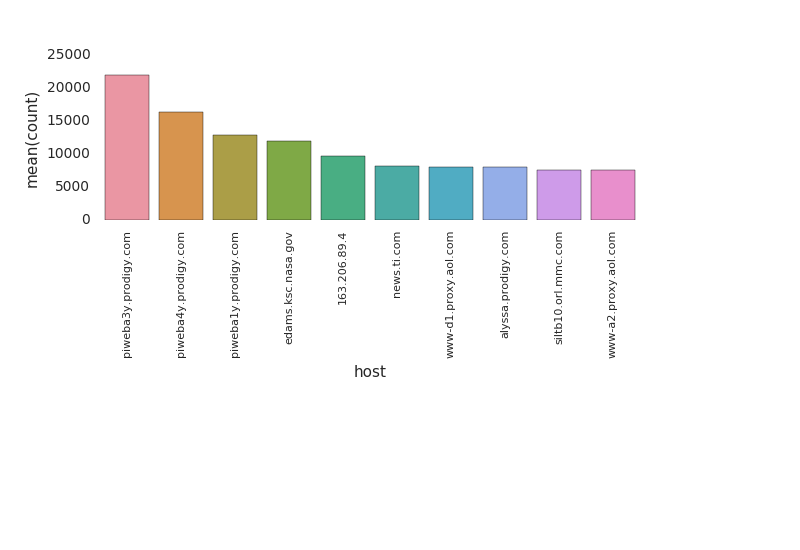

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df=pd.DataFrame(rslt,columns=['host','count'])
sns.barplot(x='host',y='count',data=df)
plt.subplots_adjust(bottom=0.6, right=0.8, top=0.9)
plt.xticks(rotation="vertical",fontsize=8)
display()

##1.34 Parse and map to hosts to groups

In [42]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))
rslt=(parsed_rdd2.map(lambda x:(x[5],1))
                 .reduceByKey(lambda a,b:a+b)
                 .takeOrdered(10, lambda x: -x[1]))
rslt

Out[ 20 ]: 
[('"GET /images/NASA-logosmall.gif HTTP/1.0"', 207520),
 ('"GET /images/KSC-logosmall.gif HTTP/1.0"', 164487),
 ('"GET /images/MOSAIC-logosmall.gif HTTP/1.0"', 126933),
 ('"GET /images/USA-logosmall.gif HTTP/1.0"', 126108),
 ('"GET /images/WORLD-logosmall.gif HTTP/1.0"', 124972),
 ('"GET /images/ksclogo-medium.gif HTTP/1.0"', 120704),
 ('"GET /ksc.html HTTP/1.0"', 83209),
 ('"GET /images/launch-logo.gif HTTP/1.0"', 75839),
 ('"GET /history/apollo/images/apollo-logo1.gif HTTP/1.0"', 68759),
 ('"GET /shuttle/countdown/ HTTP/1.0"', 64467)]

##1.35  Plot counts of HTTP Requests

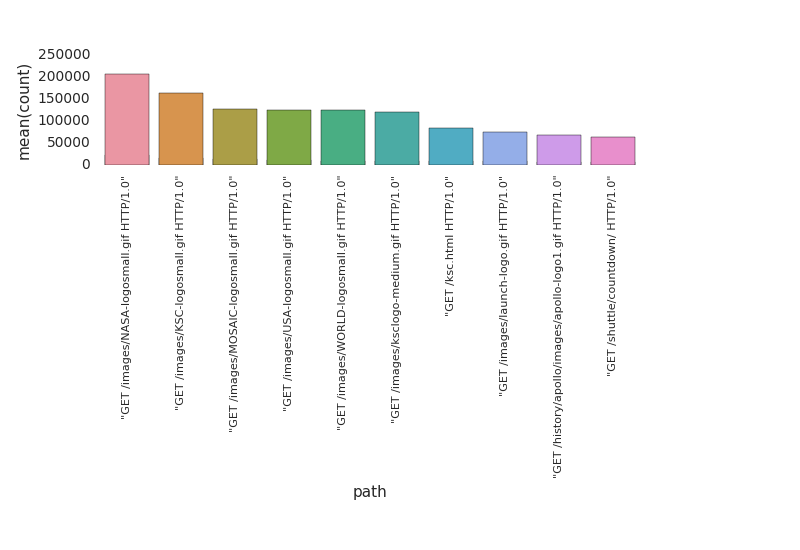

In [44]:
import seaborn as sns
df=pd.DataFrame(rslt,columns=['path','count'])
sns.barplot(x='path',y='count',data=df)
plt.subplots_adjust(bottom=0.7, right=0.8, top=0.9)
plt.xticks(rotation="vertical",fontsize=8)
display()

## 1.36 Compute counts of HTTP response status

In [46]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))
rslt=(parsed_rdd2.map(lambda x:(x[7],1))
                 .reduceByKey(lambda a,b:a+b)
                 .takeOrdered(10, lambda x: -x[1]))
rslt

Out[ 22 ]: 
[('200', 3095682),
 ('304', 266764),
 ('302', 72970),
 ('404', 20625),
 ('403', 225),
 ('500', 65),
 ('501', 41)]

##1.37 Plot counts of HTTP response status'

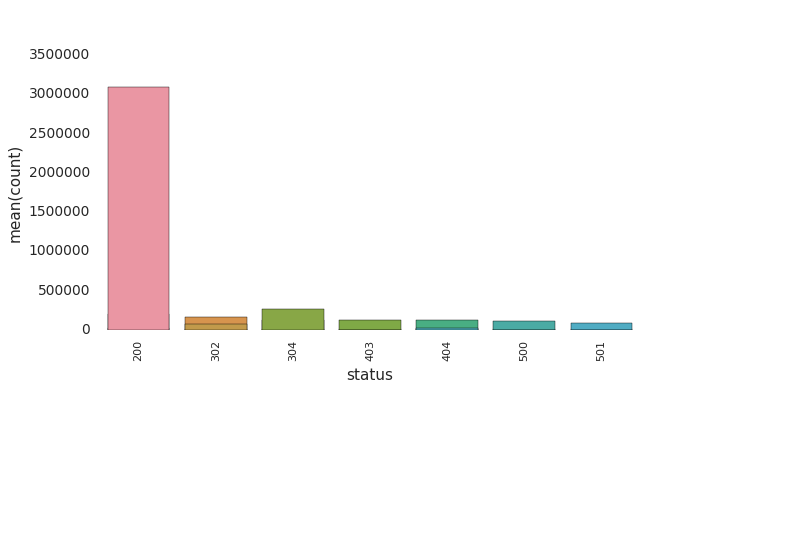

In [48]:
import seaborn as sns
df=pd.DataFrame(rslt,columns=['status','count'])
sns.barplot(x='status',y='count',data=df)
plt.subplots_adjust(bottom=0.4, right=0.8, top=0.9)
plt.xticks(rotation="vertical",fontsize=8)
display()

##1.38Compute content size

In [50]:
parsed_rdd = rdd.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_rdd2 = parsed_rdd.map(lambda line: map2groups(line))
rslt=(parsed_rdd2.map(lambda x:(x[8],1))
                 .reduceByKey(lambda a,b:a+b)
                 .takeOrdered(10, lambda x: -x[1]))
rslt

Out[ 24 ]: 
[('0', 280017),
 ('786', 167281),
 ('1204', 140505),
 ('363', 111575),
 ('234', 110824),
 ('669', 110056),
 ('5866', 107079),
 ('1713', 66904),
 ('1173', 63336),
 ('3635', 55528)]

##1.39 Plot content size

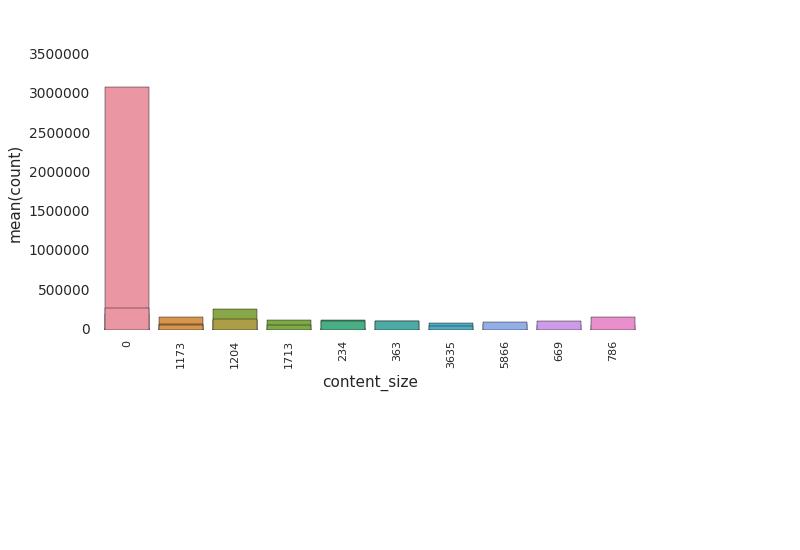

In [52]:
import seaborn as sns
df=pd.DataFrame(rslt,columns=['content_size','count'])
sns.barplot(x='content_size',y='count',data=df)
plt.subplots_adjust(bottom=0.4, right=0.8, top=0.9)
plt.xticks(rotation="vertical",fontsize=8)
display()